In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import json
import torch
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import pandas as pd
from collections import defaultdict

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, balanced_accuracy_score, euclidean_distances

from scipy.spatial.distance import cosine

from metrics import acc

from data import get_training_and_validation_data
from autoencoder import Autoencoder, VariationalAutoencoder, CategoricalAutoencoder, ConvolutionalCategoricalAutoencoder

model_id = 'YY7MJISJDQ'
model_config = json.load(open(Path('models') / model_id / 'config.json', 'r'))
dataset_id = model_config['dataset_id']
model_type = model_config['model']

X_train, y_train, X_val, y_val = get_training_and_validation_data(
    Path('processed_data'), dataset_id, balanced=True)
# X_mean, X_std = X_train.mean(), X_train.std()
# X_train -= X_mean
# X_train /= X_std
# X_val -= X_mean
# X_val /= X_std

X_min, X_max = X_train.min(), X_train.max()
X_train -= X_min
X_train /= (X_max - X_min)
X_val -= X_min
X_val /= (X_max - X_min)
X_train_tensor = torch.from_numpy(X_train).to(torch.float32)
X_val_tensor = torch.from_numpy(X_val).to(torch.float32)

if model_config['model'] == 'vae':
    model = VariationalAutoencoder
elif model_config['model'] == 'cae':
    model = CategoricalAutoencoder
elif model_config['model'] == 'convcae':
    model = ConvolutionalCategoricalAutoencoder
else:
    model = Autoencoder

autoencoder = model(input_dim=X_train.shape[1], **model_config)
autoencoder.load_state_dict(torch.load(Path('models') / model_id / 'ae.pth'))
autoencoder.eval()

if model_type == 'cae' or model_type == 'convcae':
    p = autoencoder.encode(X_train_tensor)
    X_train_enc = autoencoder.reparameterize(p, temperature=model_config['temperature'])
elif model_type == 'vae':
    X_train_mu, X_train_log = autoencoder.encode(X_train_tensor)
    X_train_enc = autoencoder.reparameterize(X_train_mu, X_train_log)
else:
    X_train_enc = autoencoder.encode(X_train_tensor)
X_train_rec = autoencoder.decode(X_train_enc)
print('MSE LOSS:', torch.nn.functional.mse_loss(X_train_tensor, X_train_rec).item())
X_train_rec = X_train_rec.detach().numpy()
X_train_enc = X_train_enc.detach().numpy()

if model_type == 'cae' or model_type == 'convcae':
    p = autoencoder.encode(X_val_tensor)
    X_val_enc = autoencoder.reparameterize(p, temperature=model_config['temperature'])
elif model_type == 'vae':
    X_val_mu, X_val_log = autoencoder.encode(X_val_tensor)
    X_val_enc = autoencoder.reparameterize(X_val_mu, X_val_log)
else:
    X_val_enc = autoencoder.encode(X_val_tensor)
X_val_rec = autoencoder.decode(X_val_enc).detach().numpy()
X_val_enc = X_val_enc.detach().numpy()

MSE LOSS: 0.00014702514454256743


# Visualization

In [ ]:
data = pd.DataFrame(X_train_enc, columns=[f'Dim_{i+1}' for i in range(X_train_enc.shape[1])])
data['Class'] = y_train

# Plot violin plots for each dimension
for column in data.columns[:-1]:  # Exclude the 'Class' column for the plots
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Class', y=column, data=data, hue='Class', palette='muted', legend=False)
    plt.title(f'Violin Plot of {column}')
    plt.xlabel('Class')
    plt.ylabel(column)
    plt.show()

3.9297347775906033e-07


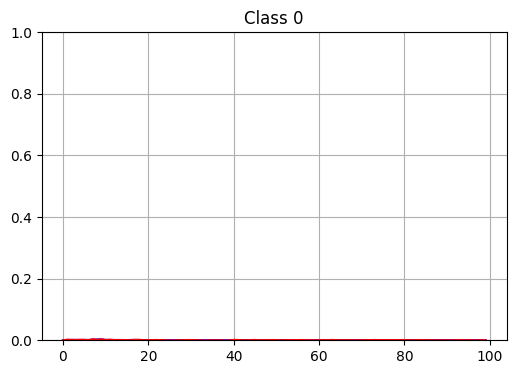

1.6266498850461125e-06


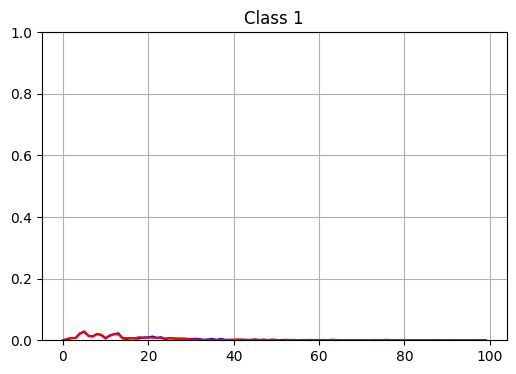

4.114287991204621e-05


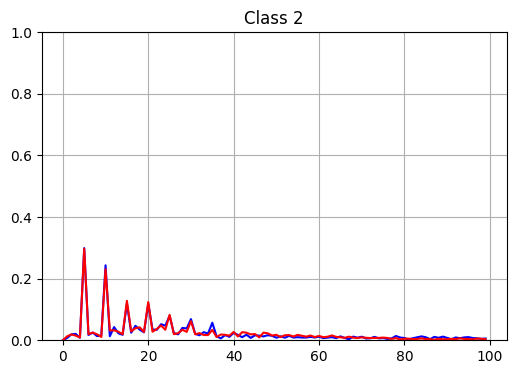

6.416377614077104e-05


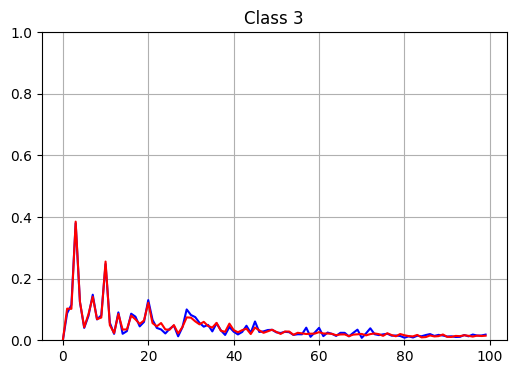

In [2]:
samples = {}
for class_label in range(4):
    indices = np.where(y_train == class_label)[0]
    random_index = np.random.choice(indices)
    samples[class_label] = X_train[random_index], X_train_rec[random_index]

for class_label, (sample, rec_sample) in samples.items():
    plt.figure(figsize=(6, 4))
    plt.plot(sample, color='b')
    plt.plot(rec_sample, color='r')
    print(((sample - rec_sample)**2).mean())
    plt.title(f"Class {class_label}")
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

# Evaluation

In [65]:
mean, std = X_train_enc.mean(), X_train_enc.std()
X_train_enc -= mean
X_train_enc /= std
X_val_enc -= mean
X_val_enc /= std

kmeans = KMeans(n_clusters=4)
kmeans.fit(X_train_enc)
y_pred = kmeans.predict(X_val_enc)
_, label_mapping = acc(y_val, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2118
           1       0.83      0.83      0.83     15035
           2       1.00      0.58      0.73      9923
           3       0.94      0.97      0.96      1555

    accuracy                           0.69     28631
   macro avg       0.69      0.59      0.63     28631
weighted avg       0.83      0.69      0.74     28631



/home/timodw/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [93]:
gmm = GaussianMixture(n_components=4)
gmm.fit(X_train_enc)
y_pred = gmm.predict(X_val_enc)
_, label_mapping = acc(y_val, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2118
           1       0.86      0.90      0.88     15035
           2       1.00      0.77      0.87      9923
           3       0.95      0.94      0.95      1555

    accuracy                           0.79     28631
   macro avg       0.70      0.65      0.67     28631
weighted avg       0.85      0.79      0.81     28631



# Distance based clustering

In [2]:
import numpy as np
from distance_matrix import dtw_njit, dtw_c

_ = dtw_njit(np.random.randn(100), np.random.randn(100))
_ = dtw_c(np.random.randn(100), np.random.randn(100))

In [3]:
from data import load_dataset
from distance_matrix import parallel_distance_matrix

X, y = load_dataset(Path('processed_data'), dataset_id='RTAGXFQJ4T') # FFT
# X, y = load_dataset(Path('processed_data'), dataset_id='K6WZL7BWHQ') # Raw
X, y = X[0][:, :, 0], y[0]
indices = np.random.choice(len(X), 500)
X, y = X[indices], y[indices]
print(X.shape, np.unique(y, return_counts=True))

distances = parallel_distance_matrix(X)
sums = distances.sum(axis=1)
distances = distances / sums[:, np.newaxis]

(500, 100) (array([0, 1, 2, 3]), array([ 29, 190, 239,  42]))


In [86]:
sums = distance_matrix.sum(axis=1)
distance_matrix = distance_matrix / sums[:, np.newaxis]

In [87]:
from sklearn.cluster import AgglomerativeClustering,  DBSCAN
from collections import defaultdict

def cluster_time_series(distance_matrix, n_clusters=None):
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    labels = clustering_model.fit_predict(distance_matrix)
    return labels

clusters = cluster_time_series(distance_matrix, n_clusters=10)
cluster_label_mapping = defaultdict(list)
for label, cluster in zip(y, clusters):
    cluster_label_mapping[cluster].append(label)

for i in range(len(cluster_label_mapping)):
    l, c = np.unique(cluster_label_mapping[i], return_counts=True)
    print(f"Cluster {i} -> {l.tolist(), c.tolist()}")
print()
for i in range(len(cluster_label_mapping)):
    l, c = np.unique(cluster_label_mapping[i], return_counts=True)
    print(f"Cluster {i} -> {l[np.argmax(c)]} ({(np.max(c) / np.sum(c)):.2%})")

Cluster 0 -> ([2, 3], [10, 24])
Cluster 1 -> ([2, 3], [36, 6])
Cluster 2 -> ([2, 3], [18, 1])
Cluster 3 -> ([2], [120])
Cluster 4 -> ([2, 3], [21, 1])
Cluster 5 -> ([0, 1, 2, 3], [21, 201, 14, 1])
Cluster 6 -> ([2], [6])
Cluster 7 -> ([2], [5])
Cluster 8 -> ([2], [2])
Cluster 9 -> ([2], [13])

Cluster 0 -> 3 (70.59%)
Cluster 1 -> 2 (85.71%)
Cluster 2 -> 2 (94.74%)
Cluster 3 -> 2 (100.00%)
Cluster 4 -> 2 (95.45%)
Cluster 5 -> 1 (84.81%)
Cluster 6 -> 2 (100.00%)
Cluster 7 -> 2 (100.00%)
Cluster 8 -> 2 (100.00%)
Cluster 9 -> 2 (100.00%)


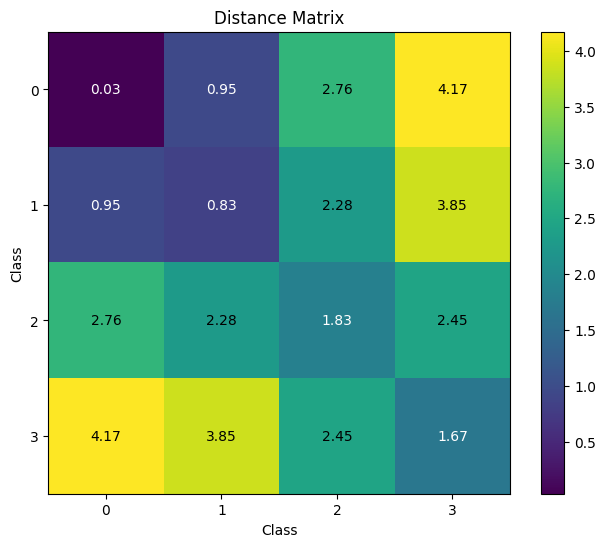

In [88]:
distance_dict = defaultdict(list)
for i in range(500):
    for j in range(i + 1, 500):
        l_i, l_j = y[i], y[j]
        distance_dict[(min(l_i, l_j), max(l_i, l_j))].append(distance_matrix[i, j] * 1000)

mean_dict = {k: np.mean(v) for k, v in distance_dict.items()}
max_index = max(max(k) for k in mean_dict.keys()) + 1
matrix = np.full((max_index, max_index), np.nan)

# Populate the distance matrix
for (i, j), distance in mean_dict.items():
    matrix[i, j] = distance
    matrix[j, i] = distance
plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='viridis', interpolation='none')

# Add text annotations for each cell
for i in range(max_index):
    for j in range(max_index):
        distance = matrix[i, j]
        if not np.isnan(distance):
            plt.text(j, i, f'{distance:.2f}', ha='center', va='center', color='white' if distance < 2 else 'black')

plt.title('Distance Matrix')
plt.xlabel('Class')
plt.ylabel('Class')
plt.xticks(range(max_index))
plt.yticks(range(max_index))
plt.colorbar()
plt.show()

# {k: v for k, v in mean_dict.items() if k[0] == k[1]}, {k: v for k, v in mean_dict.items() if k[0] != k[1]}

In [2]:
import numpy as np
import ctypes
libdtw = ctypes.CDLL('./libdtw.so')

# Specify the argument and result types
libdtw.dtw.argtypes = [ctypes.c_int, ctypes.POINTER(ctypes.c_double), ctypes.c_int, ctypes.POINTER(ctypes.c_double)]
libdtw.dtw.restype = ctypes.c_double

# Python function to wrap the C function
def dtw(s1, s2):
    array_type1 = ctypes.c_double * len(s1)
    array_type2 = ctypes.c_double * len(s2)
    result = libdtw.dtw(len(s1), array_type1(*s1), len(s2), array_type2(*s2))
    return result

# Example usage
s1 = np.array([1.0, 2.0, 3.0])
s2 = np.array([2.0, 3.0, 4.0])
print(dtw(s1, s2))

1.4142135623730951
